In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import time

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

The `landmark_faces.txt` file on the course webpage has the locations in 2D of 68 landmark positions on 9780 faces. They are from https://susanqq.github.io/UTKFace/. In this assignment you are going to use PCA to transform these points, and feed the input into a classifier to predict the gender of each face. 

Upload your solution to https://apps.ecs.vuw.ac.nz/submit/DATA201 by 6pm on Friday 12th June at 6pm. 

Start by downloading the data and loading it into a dataframe.

In [2]:
df = pd.read_csv('landmark_faces.txt', sep=" ", header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,1_0_2_20161219140530307.jpg,-4,71,-4,96,-3,120,-1,144,9,...,136,130,135,108,139,98,140,88,139,NaN
1,1_0_2_20161219140525218.jpg,13,76,13,96,15,117,18,137,25,...,137,121,141,102,141,94,142,85,143,NaN
2,1_0_2_20161219140540938.jpg,11,62,14,84,18,105,23,127,33,...,135,135,136,109,147,99,148,90,146,NaN
3,6_1_2_20161219140554092.jpg,36,66,34,86,38,108,45,129,54,...,140,120,154,104,168,97,167,92,166,NaN
4,1_1_2_20161219140604000.jpg,-3,60,-3,85,-1,110,3,134,12,...,137,126,141,109,153,98,154,88,153,NaN


For now, we will simply extract the locations for each landmark. They are stored as $x_1 y_1 x_2 y_2 \ldots x_{68} y_{68}$ in columns 1 to 136 of the dataframe. The following code will extract them into a data array, remove the first and last columns (the filename and the last column, which is blank), and make sure that numpy knows that the data are numbers.

In [4]:
data = df.to_numpy()
data = data[:,1:-1]
data = data.astype(float)

Get the size of the data array, and store the relevant information in variables `nfaces` and `npoints`

In [5]:
nfaces, npoints = data.shape
print("{} {}".format(nfaces, npoints))

9780 136


To plot a face, take one row of the data matrix, and plot the $x$ coordinates (even-numbered indices) against $y$ coordinates (odd-numbered ones). It is helpful to use `'.-'` to plot a line as well as the points. At first this will be upside down. One way to turn it the right way up is to use 1-data on the $y$ coordinates.

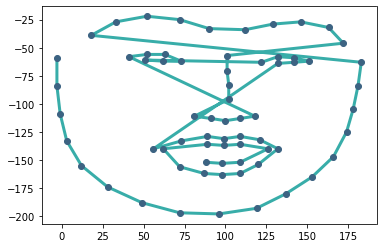

In [6]:
face = data[4]
pl.plot(face[::2], 1-(face[1::2]),'-', color='#38ada9', linewidth=3)
pl.plot(face[::2], 1-(face[1::2]),'o', color = '#3c6382', markersize=6)

The points are all meant to be matched on each face (the jargon for this is that they are 'corresponding points'). This means that to find the mean face (the average face, not a nasty-looking face) you just compute the mean of each datapoint. Compute this and plot it.

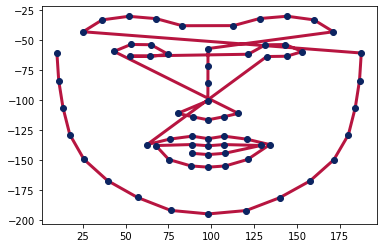

In [7]:
mean_points = np.mean(data, axis=0)
pl.plot(mean_points[0::2], 1-mean_points[1::2], '-', color='#b71540', linewidth=3)
pl.plot(mean_points[0::2], 1-mean_points[1::2], 'o', color = '#0c2461', markersize=6)

We've made the PCA algorithm a lot. Here it is again for your use. 

In [8]:
# Here is PCA

# Subtract off the mean
Z = data - mean_points

# Compute the covariance matrix
C = np.cov(Z.T)

# Get the eigenvalues and eigenvectors
evals,evecs = np.linalg.eig(C)

# Now need to sort them into descending order
indices = np.argsort(evals)
indices = indices[::-1]
evecs = evecs[:,indices]
evals = evals[indices]

# Transform the data
newdata = np.dot(Z, evecs)
newdata

array([[ 1.51075747e+01,  4.45351127e+01, -2.70876248e+01, ...,
        -8.70254115e-02,  5.19442691e-03,  1.85535201e-01],
       [-2.68442070e+01,  4.80654703e+01, -3.19136447e+01, ...,
         1.31049520e-01, -3.85654002e-01,  3.36220834e-02],
       [-4.43991541e+01, -2.00963925e+00, -2.51369001e+01, ...,
        -4.19986364e-01,  2.58111825e-01,  5.36453208e-01],
       ...,
       [-4.13029519e+00, -2.56470272e+01, -1.84527494e+01, ...,
         2.66547407e-01,  2.90493378e-01, -1.24834955e-01],
       [-2.06792748e+01, -2.52999978e+01,  2.30844453e+01, ...,
         1.42926961e-01, -1.42641704e-01, -2.55764792e-01],
       [ 2.81662919e+01, -2.06048621e+01, -1.29233591e+00, ...,
        -3.67411483e-01, -5.13240937e-02, -1.29443573e-02]])

**My own implementation of the PCA algorithm:**

In [9]:
# subtract off the mean from the matrix so all points have mean 0
data_new = data - mean_points

# transpose the centered matrix
data_trans = data_new.T

# get the covariance matrix
covariance = np.cov(data_trans)

# now calculate the eigenvalues and eigenvectors of the covariance matrix
eigvals, eigvecs = np.linalg.eig(covariance)

# then sort the eigenvalues and their corresponding eigenvectors
i = eigvals.argsort()[::-1]   
eigvals = eigvals[i]
eigvecs = eigvecs[:,i]

# get the PCA matrix by multiplying the centered matrix 
# by the eigenvectors
PCA_data = np.dot(data_new, eigvecs)
print(PCA_data)

# Test if both Stephen's algorithm and my algorithm are equal
(newdata==PCA_data).all()

[[ 1.51075747e+01  4.45351127e+01 -2.70876248e+01 ... -8.70254115e-02
   5.19442691e-03  1.85535201e-01]
 [-2.68442070e+01  4.80654703e+01 -3.19136447e+01 ...  1.31049520e-01
  -3.85654002e-01  3.36220834e-02]
 [-4.43991541e+01 -2.00963925e+00 -2.51369001e+01 ... -4.19986364e-01
   2.58111825e-01  5.36453208e-01]
 ...
 [-4.13029519e+00 -2.56470272e+01 -1.84527494e+01 ...  2.66547407e-01
   2.90493378e-01 -1.24834955e-01]
 [-2.06792748e+01 -2.52999978e+01  2.30844453e+01 ...  1.42926961e-01
  -1.42641704e-01 -2.55764792e-01]
 [ 2.81662919e+01 -2.06048621e+01 -1.29233591e+00 ... -3.67411483e-01
  -5.13240937e-02 -1.29443573e-02]]


True

Compute the scree plot of the principal components and see how many you think might be useful.

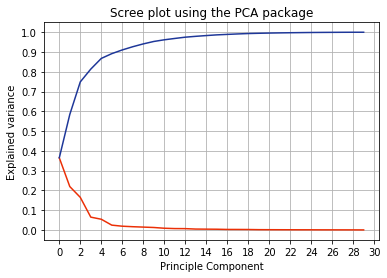

In [10]:
pca = PCA().fit(data[:30])
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# red is the explained variance
pl.plot(explained_variance, color="#eb2f06")
# blue is the cumulative explained variance
pl.plot(cumulative_explained_variance, color="#1e3799")

pl.xticks(np.arange(0, 32, 2))
pl.yticks(np.arange(0.0, 1.1, 0.1))
pl.xlabel('Principle Component')
pl.ylabel('Explained variance')
pl.title('Scree plot using the PCA package')
pl.grid()

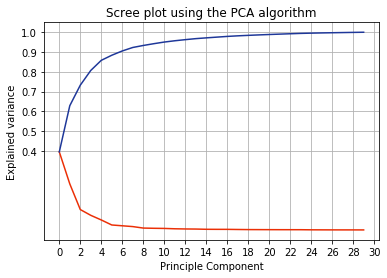

In [11]:
variance = np.var(PCA_data, axis=0)[:30]
explained_variance = variance/sum(variance)
cumulative_explained_variance = np.cumsum(explained_variance)

# red is the explained variance
pl.plot(explained_variance, color="#eb2f06")
# blue is the cumulative explained variance
pl.plot(cumulative_explained_variance, color="#1e3799")

pl.xticks(np.arange(0, 32, 2))
pl.yticks(np.arange(0.4, 1.1, 0.1))
pl.xlabel('Principle Component')
pl.ylabel('Explained variance');
pl.title('Scree plot using the PCA algorithm')
pl.grid()

Reconstruct a face from the dataset using different numbers of dimensions, and plot both the original and reconstructed face. Use this to decide how many principal components you actually need. As a hint, here is the code to reconstruct the original data. You simply need to reduce the size of the eigenvector matrix appropriately in order to reconstruct lower-dimensional versions of it.

Eigenvectors: (6, 136)
Data: (9780, 6)
Data X Eigenvectors: (9780, 136)
Y: (9780, 136)


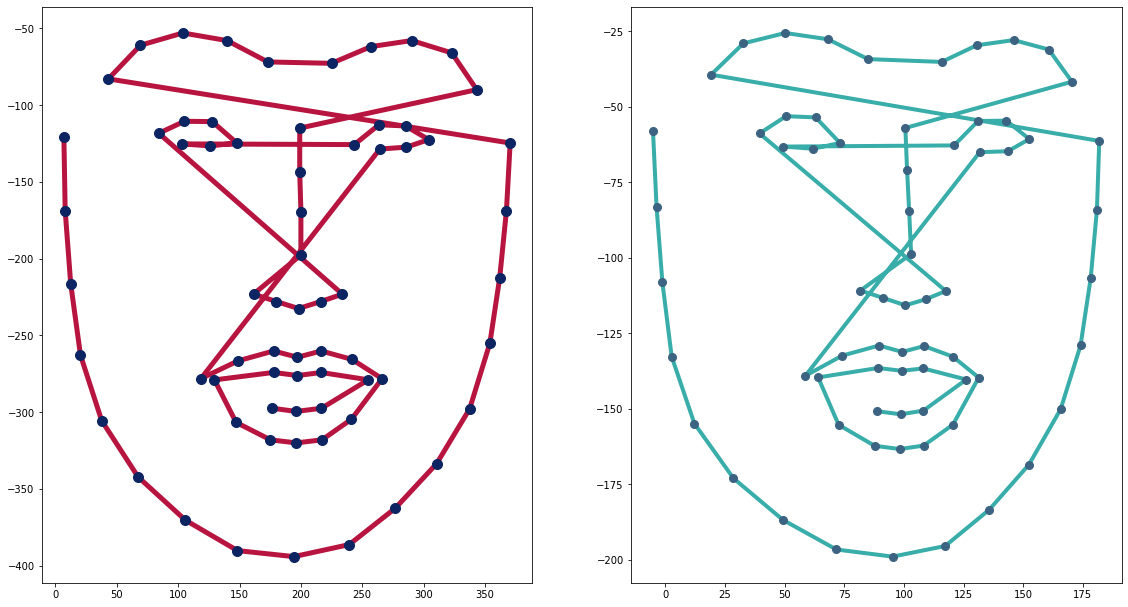

In [12]:
i = 4
pl.subplot(1, 2, 1)

original = data[i,:] + mean_points
pl.plot(original[0::2], 1-original[1::2], '-', color='#b71540', linewidth=5)
pl.plot(original[0::2], 1-original[1::2], 'o', color = '#0c2461', markersize=10)

pl.subplot(1, 2, 2)

ndim = 6
red_evec = eigvecs.T[:ndim]
red_data = PCA_data[:, :ndim]
red_matrix = np.dot(red_data, red_evec)
y = red_matrix+mean_points
pl.plot(y[i,0::2], 1-y[i,1::2],'-', color='#38ada9', linewidth=4)
pl.plot(y[i,0::2], 1-y[i,1::2],'o', color = '#3c6382', markersize=8)

print("Eigenvectors: {}".format(red_evec.shape))
print("Data: {}".format(red_data.shape))
print("Data X Eigenvectors: {}".format(red_matrix.shape))
print("Y: {}".format(y.shape))

pl.subplots_adjust(top=1, bottom=-1, right=1.5, left=-1)

The next code computes some a set of shapes. Look at the code, and explain what it is doing in a couple of sentences below. 

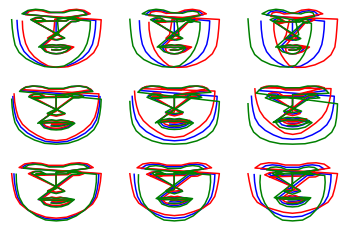

In [13]:
for pc in range(3):
    for sd in range(1,4):
        pl.subplot(3,3,pc*3+sd);
        pl.plot(mean_points[0::2],1-mean_points[1::2],'b')
        pl.plot(mean_points[0::2] - np.sqrt(eigvals[pc])*sd*eigvecs[0::2,pc],1 - (mean_points[1::2] - np.sqrt(eigvals[pc])*sd*eigvecs[1::2,pc]),'r') 
        pl.plot(mean_points[0::2] + np.sqrt(eigvals[pc])*sd*eigvecs[0::2,pc],1 - (mean_points[1::2] + np.sqrt(eigvals[pc])*sd*eigvecs[1::2,pc]),'g')         
        pl.axis('off')

In [36]:
#np.sqrt(eigvals[0])
for pc in range(3):
    for sd in range(1,4):
        print("PC: {}, SD: {}, np.sqrt(eigvals[{}]) = {}, np.sqrt(eigvals[{}])*{} = {}, eigvecs[0,{}] = {}, np.sqrt(eigvals[{}])*{}*eigvecs[0,{}] = {}\n".format(pc, sd, pc, np.sqrt(eigvals[pc]), pc, sd, np.sqrt(eigvals[pc])*sd, pc, eigvecs[0,pc], pc, sd, pc, np.sqrt(eigvals[pc])*sd*eigvecs[0,pc]))

eigvecs[:,0]

PC: 0, SD: 1, np.sqrt(eigvals[0]) = 45.560525254188114, np.sqrt(eigvals[0])*1 = 45.560525254188114, eigvecs[0,0] = -0.2645674158365592, np.sqrt(eigvals[0])*1*eigvecs[0,0] = -12.053830430656843

PC: 0, SD: 2, np.sqrt(eigvals[0]) = 45.560525254188114, np.sqrt(eigvals[0])*2 = 91.12105050837623, eigvecs[0,0] = -0.2645674158365592, np.sqrt(eigvals[0])*2*eigvecs[0,0] = -24.107660861313686

PC: 0, SD: 3, np.sqrt(eigvals[0]) = 45.560525254188114, np.sqrt(eigvals[0])*3 = 136.68157576256434, eigvecs[0,0] = -0.2645674158365592, np.sqrt(eigvals[0])*3*eigvecs[0,0] = -36.16149129197053

PC: 1, SD: 1, np.sqrt(eigvals[1]) = 35.0141909440316, np.sqrt(eigvals[1])*1 = 35.0141909440316, eigvecs[0,1] = -0.07018863299965857, np.sqrt(eigvals[1])*1*eigvecs[0,1] = -2.457598197950602

PC: 1, SD: 2, np.sqrt(eigvals[1]) = 35.0141909440316, np.sqrt(eigvals[1])*2 = 70.0283818880632, eigvecs[0,1] = -0.07018863299965857, np.sqrt(eigvals[1])*2*eigvecs[0,1] = -4.915196395901204

PC: 1, SD: 3, np.sqrt(eigvals[1]) = 35.0

array([-2.64567416e-01, -5.00524063e-02, -2.57674646e-01, -1.53949190e-02,
       -2.58340315e-01,  1.72615101e-02, -2.61988542e-01,  4.66165357e-02,
       -2.43796271e-01,  6.09402363e-02, -2.01842185e-01,  5.82725065e-02,
       -1.49259297e-01,  4.13915198e-02, -9.65726180e-02,  1.23546571e-02,
       -7.79452796e-02, -3.57709448e-03, -9.94159387e-02, -1.99425488e-02,
       -1.52473913e-01, -4.82408965e-02, -2.05938102e-01, -6.44900429e-02,
       -2.48586685e-01, -6.62349993e-02, -2.67350637e-01, -5.14634188e-02,
       -2.63484639e-01, -2.09250007e-02, -2.60970615e-01,  1.13193163e-02,
       -2.66814231e-01,  4.47604494e-02, -9.00768918e-02, -2.87704065e-02,
       -3.81081256e-02, -2.59316673e-02, -2.66217281e-04, -3.10661083e-02,
        3.35576918e-02, -2.68240272e-02,  6.04812379e-02, -1.38433786e-02,
        6.29279686e-02,  1.18356644e-02,  3.68934814e-02,  2.46092149e-02,
        4.40419156e-03,  2.87168429e-02, -3.24755640e-02,  2.36465777e-02,
       -8.39722253e-02,  

**The code shifts the mean points by a magnitude determined by the eigenvalue in the direction of it's corresponding eigenvector. We know that an eigenvector is a special vector that doesn't change direction when linearly transformed, it can only shrink or expand in a particular direction. This shrinkage or expansion is done via it's magnitude, in other words it's eigenvalue. So essentially what this code is doing is looping through the first 3 principle components and offsetting the mean face by the square root of it's eigenvalue(I'll just say eigenvalue instead of squareroot of the eigenvalue from now on) in the direction of it's corresponding eigenvector(each column is a vector). For each of the PCs(these are the different rows) it plots 3 different eigenvalues, the eigenvalue itself, the eigenvalue doubled and the eigenvalue tripled (these are the different columns). For each of the individual plots: the blue face is the mean face, the red face is the mean face shifted negatively and the green face is shifted positively. This not only shows us the differing principle components and how they compare but also the effect of the magnitude on the eigenvector.**

To get training labels, look at the names of the images (which are in df[:,0]). The names are age_gender_race_date.jpg. We are interested in the gender, which is 0 or 1 for male and female (I'm not sure which is which, and it doesn't matter). Extract that digit (`stringname.find()` might be helpful, where stringname is a variable) and store it as the target variable. There is one error in the data, which is index 8513. I think you should assign it to category 0. 

In [15]:
col_names = df.iloc[:, 0]
genders = pd.to_numeric(col_names.str.split('_', expand=True).iloc[:, 1])
genders[8513] = 0
genders

0       0
1       0
2       0
3       1
4       1
       ..
9775    0
9776    0
9777    0
9778    1
9779    0
Name: 1, Length: 9780, dtype: int64

Now use a classification algorithm such as Support Vector Classifier from sklearn to classify the faces based on (i) the original data, and (ii) some small number of principal components. You should compare both the accuracy and time to train. Don't forget ot split the data into training and testing. You might find that very small numbers of principal components are good for this. 

In [16]:
start = time.time()

y_train, y_test, X_train, X_test = train_test_split(genders, data, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
knn_model = knn.fit(X_train, y_train)
knn_score = accuracy_score(y_train, knn_model.predict(X_train))

end = time.time()
og_time = (end-start)
print("Original Dataset Execution Time:\n {:.4f}ms".format(og_time))
print("Original Dataset Accuracy Score:\n {:.2f}%".format(knn_score*100))
print("Original Dataset Confusion Matrix:\n {}".format(confusion_matrix(y_test, knn_model.predict(X_test))))

Original Dataset Execution Time:
 10.3707ms
Original Dataset Accuracy Score:
 80.02%
Original Dataset Confusion Matrix:
 [[484 387]
 [222 863]]


In [17]:
red_start = time.time()

red_X_train, red_X_test = train_test_split(red_data, test_size=0.2, random_state=42)
red_knn = KNeighborsClassifier(n_neighbors=5)
red_knn_model = red_knn.fit(red_X_train, y_train)
red_knn_score = accuracy_score(y_train, red_knn_model.predict(red_X_train))

red_end = time.time() 
red_time = (red_end-red_start)
print("Reduced Dataset Execution Time:\n {:.2f}ms".format(red_time))
print("Reduced Dataset Accuracy Score:\n {:.2f}%".format(red_knn_score*100))
print("Reduced Dataset Confusion Matrix:\n {}".format(confusion_matrix(y_test, red_knn_model.predict(red_X_test))))

Reduced Dataset Execution Time:
 0.30ms
Reduced Dataset Accuracy Score:
 76.44%
Reduced Dataset Confusion Matrix:
 [[464 407]
 [272 813]]


In [18]:
print("A PC of {} is {:.2f}ms faster than the data with all PCs but is less accurate by {:.2f}%".format(ndim, og_time-red_time, (knn_score-red_knn_score)*100))

A PC of 6 is 10.07ms faster than the data with all PCs but is less accurate by 3.58%
